# Multi-Armed Bandits with Thompson Sampling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import beta
# from astroML.plotting import setup_text_plots
# setup_text_plots(fontsize=8, usetex=True)

/Users/shyam/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Google Play Store data from Kaggle : https://www.kaggle.com/lava18/google-play-store-apps#googleplaystore_user_reviews.csv
## For our purposes, we'll only use the App column and the Sentiment Column to figure out which app is associated with the most positive sentiment

In [3]:
train_data = pd.read_csv("../../data/googleplaystore_user_reviews.csv")
train_data = train_data.drop(columns=["Translated_Review","Sentiment_Polarity","Sentiment_Subjectivity"])
train_data = train_data.dropna()
train_data.head(10)

,App,Sentiment
0,10 Best Foods for You,Positive
1,10 Best Foods for You,Positive
3,10 Best Foods for You,Positive
4,10 Best Foods for You,Positive
5,10 Best Foods for You,Positive
6,10 Best Foods for You,Positive
8,10 Best Foods for You,Neutral
9,10 Best Foods for You,Neutral
10,10 Best Foods for You,Positive
11,10 Best Foods for You,Positive


#### There are 1074 unique apps

In [3]:
apps = train_data["App"]

In [4]:
train_data["App"] = pd.factorize(apps)[0]

In [5]:
train_data.head(10)

,App,Sentiment
0,0,Positive
1,0,Positive
3,0,Positive
4,0,Positive
5,0,Positive
6,0,Positive
8,0,Neutral
9,0,Neutral
10,0,Positive
11,0,Positive


#### We can see here that there are 3 unique Sentiment values. To make the likelihood distribution Bernoulli, we'll treat Neutral values as Negative. 

In [6]:
train_data["Sentiment"] = np.where(train_data["Sentiment"] == "Positive",1,0)
train_data.head(10)

,App,Sentiment
0,0,1
1,0,1
3,0,1
4,0,1
5,0,1
6,0,1
8,0,0
9,0,0
10,0,1
11,0,1


In [7]:
train = np.array(train_data)

### Arm Class

In [8]:
class Arm():
    """
        Arm class that is used to sample from a beta prior
        Parameters:
            prior: a & b params for beta distribution
            trials: success and failure trials
    """
    def __init__(self):
        self.prior = np.ones(2) #start with uniform prior
        self.trials = np.zeros(2) #success, failure
        
    def moments(self):
        expectation = self.prior[0] / (self.prior[0] + self.prior[1])
        variance = (self.prior[0]*self.prior[1]) / (((self.prior[0] + self.prior[1])**2)*(np.sum(self.prior) - 1))
        return expectation, variance
    
    def update(self,response): #update prior
        arr = np.zeros(2)
        arr[1-response] = 1
        self.trials[1-response] += 1
        self.prior += arr
    
    def generate_sample_prior(self):
        return np.random.beta(self.prior[0],self.prior[1]) #sample

### BernoulliMultiArmedBandit Class

In [9]:
#np.random.choice(10)

5

In [10]:
class BernoulliMultiArmedBandit():
    """
        Main Bernoulli Multi Armed Bandit class
        Uses Thompson sampling to greedily choose arms by picking the one with the highest sampled prior.
        Epsilon Greedy strategy is also added for exploration
        Parameters:
            data: two columns, 1st is bandit ids, 2nd is binary denoting success
            epsilon: exploration value
            decay: exploration decay
            num_arms: number of arms
            indices: indices for each arm
            sampled_priors: sampled priors for each arm
            arms: Arm() objects
            final_values: final values
    """
    def __init__(self,data,num_arms,epsilon=0.9,decay=0.95):
        self.epsilon = epsilon
        self.decay = decay
        self.data = data
        self.num_arms = num_arms
        self.indices = self.generate_indices()
        self.sampled_priors = np.zeros(self.num_arms)
        self.arms = [Arm() for i in range(num_arms)]
        self.final_values = {}
    
    def reset(self):
        self.sampled_priors = np.zeros(self.num_arms)
        self.arms = [Arm() for i in range(self.num_arms)]
        self.final_values = {}
    
    def generate_indices(self):
        indices = {}
        for i in range(self.num_arms):
            indices[i] = np.where(self.data[:,0] == i)[0]
        return indices
    
    def return_final_values(self):
        for i in range(self.num_arms):
            arm = self.arms[i]
            prior = arm.prior
            expectation, variance = arm.moments()
            vals = [prior[0],prior[1],expectation,variance]
            self.final_values[i] = vals
        
    def act(self):
        if np.random.rand() < self.epsilon:
            self.epsilon *= self.decay
            arm_index = np.random.choice(self.num_arms)
        else:
            for i in range(self.num_arms):
                arm = self.arms[i]
                self.sampled_priors[i] = arm.generate_sample_prior()
            arm_index = np.argmax(self.sampled_priors)
        arm = self.arms[arm_index]
        response = self.data[np.random.choice(self.indices[arm_index])][-1]
        arm.update(response)
        
    def train(self,iterations=1000):
        self.reset()
        bar = tqdm(np.arange(iterations))
        for i in bar:
            self.act()
            bar.set_description("Epsilon: %s" % str(self.epsilon))
        self.return_final_values()

In [11]:
bma = BernoulliMultiArmedBandit(train,train[-1][0])

In [12]:
bma.train(100000)

Epsilon: 0.00015471477969685924: 100%|██████████| 100000/100000 [11:53<00:00, 140.09it/s]


In [13]:
result_data_frame = pd.DataFrame.from_dict(bma.final_values,
                                           orient='index',columns=["a","b","expected_value","variance"])

In [14]:
first_2 = list(np.argsort(result_data_frame["expected_value"])[::-1][:2])
last_3 = list(np.argsort(result_data_frame["expected_value"])[:3])

In [15]:
first_2.extend(last_3)

In [21]:
first_2

[486, 264, 309, 611, 161]

In [16]:
final_data = np.array(result_data_frame)

In [17]:
data = final_data[first_2][:,:2]
data

array([[1.5944e+04, 1.0000e+00],
       [1.3484e+04, 1.0000e+00],
       [1.0000e+00, 3.0000e+00],
       [1.0000e+00, 3.0000e+00],
       [1.0000e+00, 3.0000e+00]])

In [18]:
data[:,0]

array([1.5944e+04, 1.3484e+04, 1.0000e+00, 1.0000e+00, 1.0000e+00])

In [19]:
def plot_prior():
    alpha_values = data[:,0]
    beta_values = data[:,1]
    linestyles = ['-', '--', ':', '-.']
    x = np.linspace(0, 1, 1002)[1:-1]

    #------------------------------------------------------------
    # plot the distributions
    fig, ax = plt.subplots(figsize=(5, 3.75))

    for a, b, ls in zip(alpha_values, beta_values, linestyles):
        dist = beta(a, b)

        plt.plot(x, dist.pdf(x), ls=ls, c='black',
                 label='alpha=%.1f, beta=%.1f' % (a, b))

    plt.xlim(0, 1)
    plt.ylim(0, 3)

    plt.xlabel('x')
    plt.ylabel('p(x|alpha,beta)')
    plt.title('Beta Distribution')

    plt.legend(loc=0)
    plt.show()

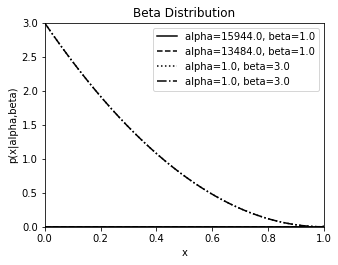

In [20]:
plot_prior()